In [1]:
import numpy as np
import random

import h5py.highlevel
import astropy.io.fits as fits
from astropy.table import Table

import pandas as pd
import seaborn as sns
sns.set(style="ticks", context="talk", font_scale=1.)

import os
import pandas as pd
import matplotlib.pyplot as plt
from astroML.datasets.tools import SDSSfits
#%matplotlib inline

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: H5pyDeprecationWarning: The h5py.highlevel module is deprecated, code should import directly from h5py, e.g. 'from h5py import File'.
  after removing the cwd from sys.path.


In [2]:
## get data, including adding noise

lines = [3869,4102,4340,4473,4489,4491,4508,4515,4520,4523,4534,4542,4549,4556,4576,4583,4621,4629,4667,4686,4731,4861,4924,4959,4993,5007,5018,5146,5169,5198,5235,5265,5276,5284,5317,5326,5338,5363,5414,5425,5876,6087,6300,6374,6563,6583,6678,6716,6731,7065]
width = 50

def _getData(filename, lower, upper, redshifted=False, addNoise=False, addFilter=False, lines = False, width=False):
    spec=SDSSfits(filename)
    z = spec.z
    data = pd.DataFrame({'lam': spec.wavelength().tolist(), 'flux': spec.spectrum.tolist()})
    if redshifted:
        data['lam'] = data['lam']/(1+z)
    data = data[(data['lam']>lower) & (data['lam']<upper)]
    lam = np.linspace(lower,upper,upper-lower+1)
    flux = np.interp(lam, data['lam'], data['flux'])
    
    ## add filters
    if addFilter:
        lam, filters = _filterTensor(lam, lines, width, begin=lower, end=upper)
        flux, filters = _filterTensor(flux, lines, width, begin=lower, end=upper)
        
    ## add noise 
    if addNoise:
        factor = np.random.uniform(low=0.2, high=1.0) # scale factor of std
        noise = np.random.normal(0, flux.std()*factor, len(flux))
        flux = flux+noise
    if not addNoise:
        factor = 0
    # normalize data
    std = np.std(flux)
    avg = np.mean(flux)
    eps = 0.001
    fluxNormalized = (flux - avg)/std
    fluxNormalized -= np.min(fluxNormalized)
    fluxNormalized += eps
    fluxNormalized /= np.max(fluxNormalized)
    dataSelected = pd.DataFrame({'lam': lam, 'flux': flux, 'fluxNormalized': fluxNormalized})

    _writefile(filename,dataSelected,z,lower, upper, factor)
    return dataSelected, z

def add_noise(flux):
    # normalize data
    std = np.std(flux)
    avg = np.mean(flux)
    eps = 0.001
    fluxNormalized = (flux - avg)/std
    fluxNormalized -= np.min(fluxNormalized)
    fluxNormalized += eps
    fluxNormalized /= np.max(fluxNormalized)
    dataSelected = pd.DataFrame({'fluxNoise': flux, 'fluxNoiseNormalized': fluxNormalized})
    #_writefile(filename,dataSelected,z,lower, upper)
    return 


def _writefile(filename,data,z,lower, upper, factor=0):
    name = os.path.splitext(filename)[0]
    if (factor !=0):
        factor =str(np.round(factor,3))
        outputName = name+'-Noise'+factor+'-'+str(int(lower))+'-'+str(int(upper))+'_raw.csv'
    else:
        outputName = name+'-'+str(int(lower))+'-'+str(int(upper))+'_raw.csv'
    f = open(outputName,'w')
    f.write('# Original file: '+str(filename)+'\n')
    f.write('# wavelength range from: '+str(lower)+' to '+str(upper)+'\n')
    f.write('# redshift: '+str(z) +'\n')
    data.to_csv(f)
    f.close()
    
    
def _filters(lines, width, Ha_width=280, Hb_width=120, Hg_width=60):
    boundery_0 = np.array([[line-width/2,line+width/2] for line in lines if line<4338]).flatten()
    boundery_Hg = np.array([4340-Hg_width/2,4340+Hg_width/2]).flatten()
    boundery_1 = np.array([[line-width/2,line+width/2] for line in lines if (line>4342 and line<4860)]).flatten()
    boundery_Hb = np.array([4861-Hb_width/2,4861+Hb_width/2]).flatten()
    boundery_2 = np.array([[line-width/2,line+width/2] for line in lines if (line>4862 and line<6560)]).flatten()
    boundery_Ha = np.array([6563-Ha_width/2,6563+Ha_width/2]).flatten()
    boundery_3 = np.array([[line-width/2,line+width/2] for line in lines if line>6566]).flatten()
    boundery = np.concatenate((boundery_0, boundery_Hg, boundery_1,boundery_Hb,boundery_2,boundery_Ha,boundery_3),axis=0).reshape(-1,2)
    # 1st filter, filter the right boundery, ignore those right right bouderies smaller than the previous one
    index = [1]
    while len(index):
        signs = np.sign(boundery[1:]-boundery[:-1])
        index = np.argwhere(signs==-1)[:,0]+1
        if len(index)>0:
            boundery = np.delete(boundery,index,0)
    #print(boundery)
    # 2nd filter, compare right boundery and next left boundery, if smaller, merge two intervals.
    boundery = boundery.flatten()
    filters = []
    filters.append(boundery[0]) 
    i = 1
    while i< (len(boundery)-1):
        if boundery[i]<boundery[i+1]:
            filters.append(boundery[i])
            i=i+1
        else: 
            i=i+2
    filters.append(boundery[-1])
    return np.array(filters).reshape(-1,2)

def _filterTensor(tensor, lines, width, begin=3800, end=7500):
    filters = _filters(lines, width).flatten()
    filters = np.insert(filters,0,begin)
    filters = np.append(filters,end)
    filters = filters.reshape(-1,2)
    filters = (filters-begin).astype(int)
    if len(tensor.shape) == 1:
        return np.concatenate([tensor[f[0]:f[1]] for f in filters],axis=0), filters
    else:
        return np.concatenate([tensor[:,f[0]:f[1]] for f in filters],axis=1), filters
    
def _filenames(dataframe):
    info= zip(dataframe['MJD'],dataframe['PLATE'],dataframe['FIBERID'])
    filenames = ['spSpec-'+str(MJD).zfill(5)+'-'+str(PLATE).zfill(4)+'-'+str(FIBERID).zfill(3)+'.fit' for MJD, PLATE, FIBERID in info]
    return filenames

## Example 

good example of 2.0: './SDSS/galaxy/spSpec-54553-1670-256.fit'

## example of filters

**AGN Emission Lines (3000 - 8000 A)**
https://ned.ipac.caltech.edu/level5/Netzer/Netzer2_1.html

```
CIII λ977
OVI λ1035
Lα
NV λ1240
OI λ1304
CII λ1336
SiIV,OIV] λ1400
NIV] λ1486
CIV λ1549 
HeII λ1640
OIII] λ1663
NIII] λ1750
CIII] λ1909
FeII λ(2200-2800)  
MgII λ2798
[NeV] λ3426
[OII] λ3727
[NeIII] λ3869
HeII λ4686
Hβ λ4861
[OIII] λ4959,5007
FeII λ(4500-5400) 
HeI λ5876
[FeVII] λ6087
[OI] λ6300
[FeX] λ6374
Hα λ6563
[NII] λ6583
[SII] λ6716,6731
CaII λ8498-8662
[SIII] λ9069,9532
```

The emission line spectrum of active galactic nuclei and the unifying scheme
https://link.springer.com/article/10.1007%2Fs001590000006

```
(Broad permmited lines)
HI, HeI λλ5876,6678,7065
He II λ4686
Fe II visible domain

(narrow line)
[Fe VII] λ6087
[Fe X] λ6375
[Fe XI] λ7892
```

add more balmer lines
```
Hγ λ4340
H-δ λ4102
```


FeII Lines, Table I in
https://arxiv.org/pdf/1004.2212.pdf


without FeII:

lines = [3869,4102,4340,4686,4861,4959,5007,5876,6087,6300,6374,6563,6583,6678,6716,6731,7065]


with Fe II:

lines = [3869,4102,4340,4473,4489,4491,4508,4515,4520,4523,4534,4542,4549,4556,4576,4583,4621,4629,4667,4686,4731,4861,4924,4959,4993,5007,5018,5146,5169,5198,5235,5265,5276,5284,5317,5326,5338,5363,5414,5425,5876,6087,6300,6374,6563,6583,6678,6716,6731,7065]

No handles with labels found to put in legend.


size of filtered spectrum 2079
size of original spectrum 3701


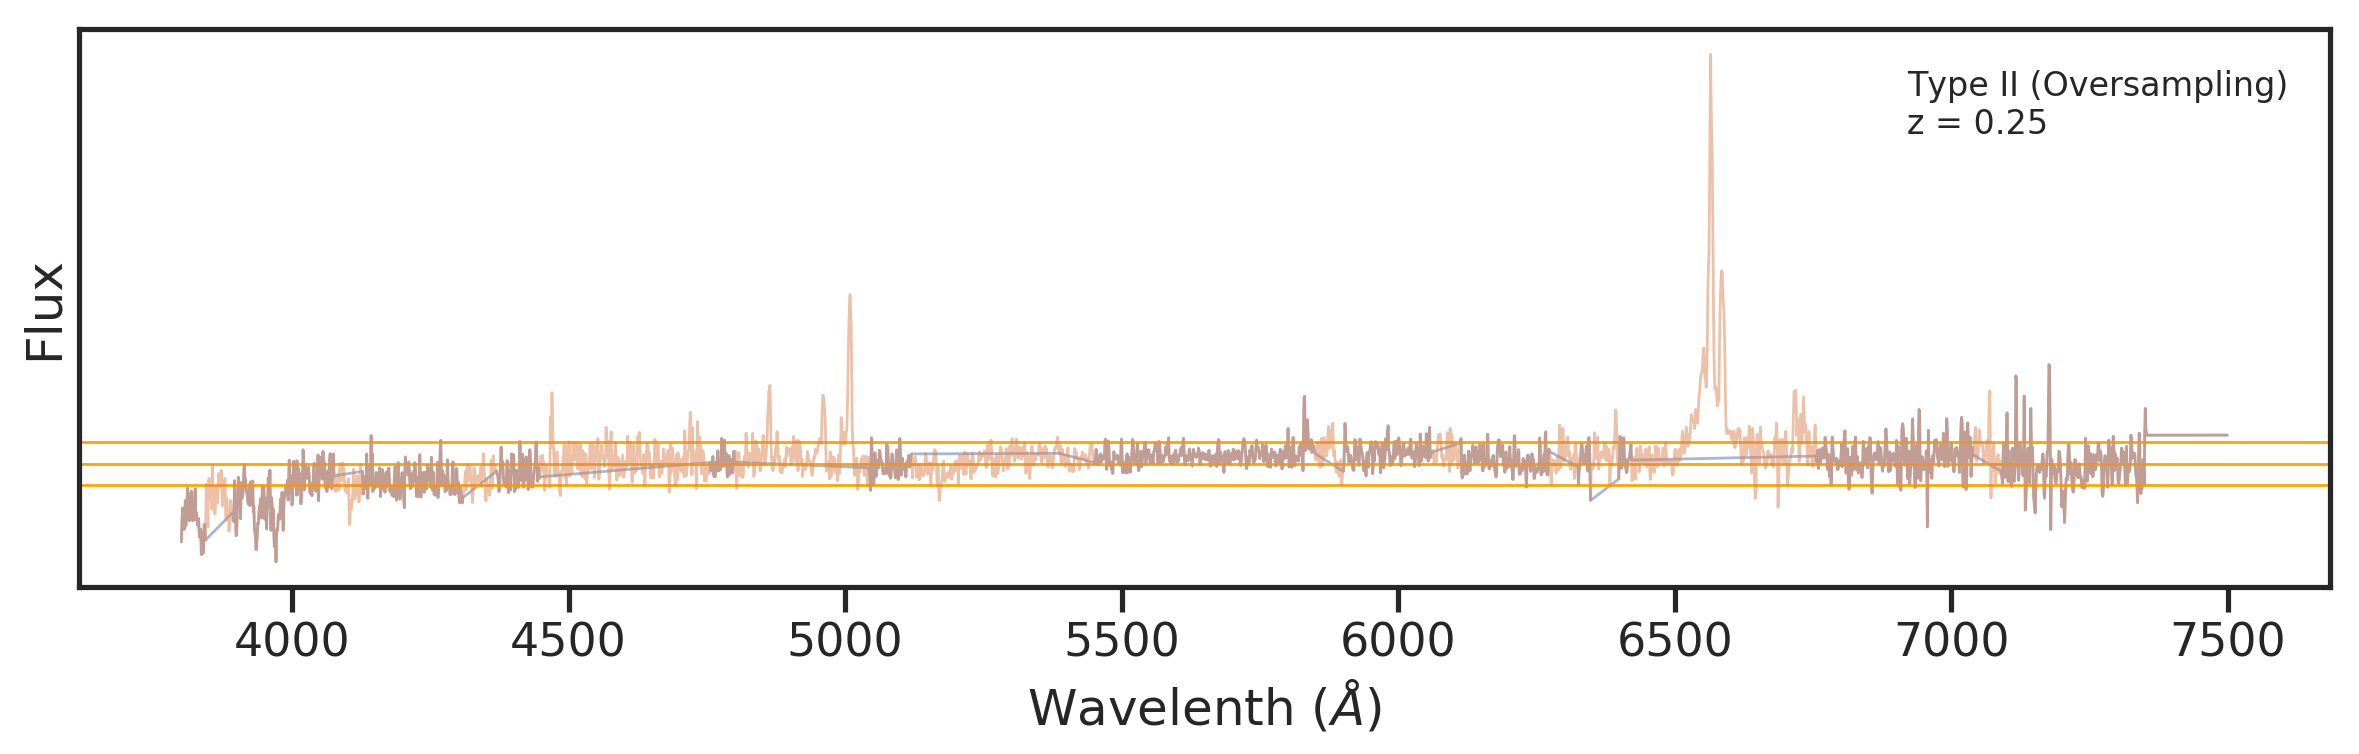

In [3]:
fig = plt.figure(figsize=(12,4))

example, z = _getData('./SDSS/galaxy/spSpec-54553-1670-256.fit', lower=3800, upper=7500, redshifted=True, addNoise=False, addFilter=True, lines = lines, width=width)

print('size of filtered spectrum', len(example))
plt.plot(example['lam'],example['flux'],linewidth=1,alpha=0.5,label='')
plt.axhline(y=example['flux'].mean(),linewidth=1,color='orange')
plt.axhline(y=example['flux'].mean()+example['flux'].std(),linewidth=1,color='orange')
plt.axhline(y=example['flux'].mean()-example['flux'].std(),linewidth=1,color='orange')

example, z = _getData('./SDSS/galaxy/spSpec-54553-1670-256.fit', lower=3800, upper=7500, redshifted=True, addNoise=False)
plt.plot(example['lam'],example['flux'],alpha=0.5,linewidth=1,label='')
print('size of original spectrum', len(example))

#example, z = _getData('./SDSS/galaxy/spSpec-54553-1670-256.fit', lower=3800, upper=7500, redshifted=True, addNoise=True)
#plt.plot(example['lam'],example['flux'],alpha=0.5,linewidth=1,label='')

plt.yticks([], [])

plt.legend(title='Type II (Oversampling)\nz = %.2f' % z,frameon=False)
plt.xlabel('Wavelenth ($\AA$)')
plt.ylabel('Flux')


fig.tight_layout()
#plt.savefig('example_seyfert19_spectrum.pdf', format='pdf')

In [4]:
## save filters and filtered wavelengths
#example['lam'].to_csv('wavelenght-lines-filtered.csv',header=['wavelength'],sep=',',index=False)
#np.savetxt('lines-filtered.csv', filters+3800, fmt= '%0.0f', delimiter=",")

In [9]:
len(example['lam'])

3701

## example of adding noise

No handles with labels found to put in legend.


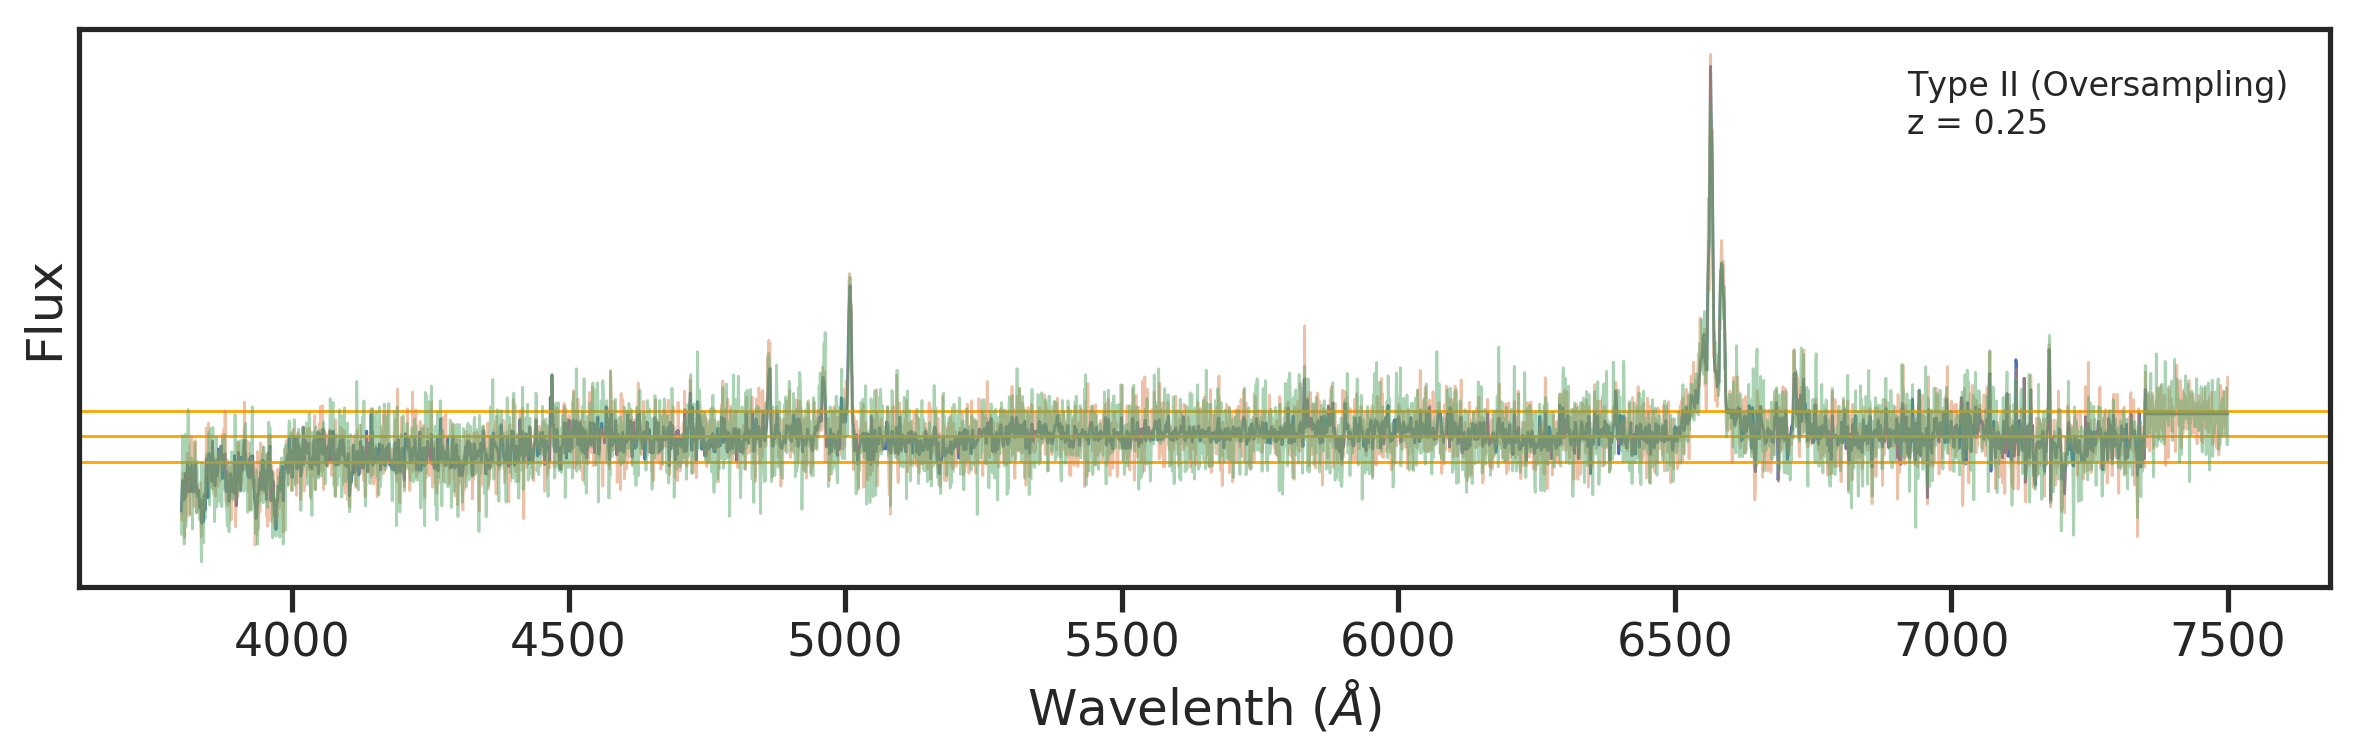

In [5]:
fig = plt.figure(figsize=(12,4))

example, z = _getData('./SDSS/galaxy/spSpec-54553-1670-256.fit', lower=3800, upper=7500, redshifted=True, addNoise=False)

plt.plot(example['lam'],example['flux'],linewidth=1,label='')
plt.axhline(y=example['flux'].mean(),linewidth=1,color='orange')
plt.axhline(y=example['flux'].mean()+example['flux'].std(),linewidth=1,color='orange')
plt.axhline(y=example['flux'].mean()-example['flux'].std(),linewidth=1,color='orange')

example, z = _getData('./SDSS/galaxy/spSpec-54553-1670-256.fit', lower=3800, upper=7500, redshifted=True, addNoise=True)
plt.plot(example['lam'],example['flux'],alpha=0.5,linewidth=1,label='')

example, z = _getData('./SDSS/galaxy/spSpec-54553-1670-256.fit', lower=3800, upper=7500, redshifted=True, addNoise=True)
plt.plot(example['lam'],example['flux'],alpha=0.5,linewidth=1,label='')

plt.yticks([], [])

plt.legend(title='Type II (Oversampling)\nz = %.2f' % z,frameon=False)
plt.xlabel('Wavelenth ($\AA$)')
plt.ylabel('Flux')


fig.tight_layout()
#plt.savefig('example_seyfert19_spectrum.pdf', format='pdf')

# Type I galaxy

In [6]:
# include all the emission

folder = './SDSS/galaxy'
filenames = [x for x in os.listdir(folder) if x.endswith(".fit")]
pixels = []
zs = []

for filename in filenames:
    try:
        data, z = _getData('./'+folder+'/'+filename, lower=3800, upper=7500, redshifted=True, addNoise=False)
        pixels.append(data['fluxNormalized'].tolist())
        zs.append(z)
    except:
        print('Missing:', filename)
        continue

pixels = np.asarray(pixels).flatten()
zs = np.asarray(zs).flatten()
csvfilename = 'archive-type1-pixels-3800-7500-redshifted-normalized.csv'
zsFilename = 'archive-type1-z02-zs-3800-7500-redshifted-normalized.csv'
pixels.tofile(csvfilename, sep=",")
zs.tofile(zsFilename, sep=",")

Exception ignored in: <bound method SDSSfits.__del__ of <astroML.datasets.tools.sdss_fits.SDSSfits object at 0x7f45a0b6ada0>>
Traceback (most recent call last):
  File "/usr/lib/python3.6/site-packages/astroML/datasets/tools/sdss_fits.py", line 115, in __del__
    gc.collect()
KeyboardInterrupt
MC1TEMDN=-0.00000000000000E+00 / sp1 mech median temp                            [astropy.io.fits.card]
MC1TBCB =-0.00000000000000E+00 / sp1 mech Temp_Blue_Cam_Bot                      [astropy.io.fits.card]


In [14]:
# lines filtered
lines = [3869,4102,4340,4473,4489,4491,4508,4515,4520,4523,4534,4542,4549,4556,4576,4583,4621,4629,4667,4686,4731,4861,4924,4959,4993,5007,5018,5146,5169,5198,5235,5265,5276,5284,5317,5326,5338,5363,5414,5425,5876,6087,6300,6374,6563,6583,6678,6716,6731,7065]
width = 50

folder = './SDSS/galaxy'
filenames = [x for x in os.listdir(folder) if x.endswith(".fit")]
pixels = []
zs = []

for filename in filenames:
    try:
        #print(filename)
        data, z = _getData('./'+folder+'/'+filename, lower=3800, upper=7500, redshifted=True, addNoise=False, addFilter=True, lines = lines, width=width)
        pixels.append(data['fluxNormalized'].tolist())
        zs.append(z)
    except:
        print('Missing:', filename)
        continue


pixels = np.asarray(pixels).flatten()
zs = np.asarray(zs).flatten()
csvfilename = 'archive-type1-pixels-3800-7500-redshifted-lines-filtered-normalized.csv'
zsFilename = 'archive-type1-zs-3800-7500-redshifted-lines-filtered-normalized.csv'
pixels.tofile(csvfilename, sep=",")
zs.tofile(zsFilename, sep=",")

MC1TEMDN=-0.00000000000000E+00 / sp1 mech median temp                            [astropy.io.fits.card]
MC1TBCB =-0.00000000000000E+00 / sp1 mech Temp_Blue_Cam_Bot                      [astropy.io.fits.card]


# Type I galaxy 0<z<0.2

In [106]:
data = pd.read_csv('./SDSS/galaxyTypeIZ02.csv',header=0,index_col=0)
filenames = _filenames(data)
folder = './SDSS/galaxy'
pixels = []
zs = []

for filename in filenames:
    try:
        #print(filename)
        data, z = _getData('./'+folder+'/'+filename, lower=3800, upper=7500, redshifted=True, addNoise=False)
        pixels.append(data['fluxNormalized'].tolist())
        zs.append(z)
    except:
        print('Missing:', filename)
        continue

pixels = np.asarray(pixels).flatten()
zs = np.asarray(zs).flatten()
pixelFilename = 'archive-type1-z02-pixels-3800-7500-redshifted-normalized.csv'
zsFilename = 'archive-type1-z02-zs-3800-7500-redshifted-normalized.csv'
pixels.tofile(pixelFilename, sep=",")
zs.tofile(zsFilename, sep=",")

Missing: spSpec-54468-1631-199.fit
Missing: spSpec-54468-1631-384.fit


In [7]:
# lines filtered
lines = [3869,4102,4340,4473,4489,4491,4508,4515,4520,4523,4534,4542,4549,4556,4576,4583,4621,4629,4667,4686,4731,4861,4924,4959,4993,5007,5018,5146,5169,5198,5235,5265,5276,5284,5317,5326,5338,5363,5414,5425,5876,6087,6300,6374,6563,6583,6678,6716,6731,7065]
width = 50

data = pd.read_csv('./SDSS/galaxyTypeIZ02.csv',header=0,index_col=0)
filenames = _filenames(data)
folder = './SDSS/galaxy'
pixels = []
zs = []

for filename in filenames:
    try:
        #print(filename)
        data, z = _getData('./'+folder+'/'+filename, lower=3800, upper=7500, redshifted=True, addNoise=False, addFilter=True, lines = lines, width=width)
        pixels.append(data['fluxNormalized'].tolist())
        zs.append(z)
    except:
        print('Missing:', filename)
        continue


pixels = np.asarray(pixels).flatten()
zs = np.asarray(zs).flatten()
pixelFilename = 'archive-type1-z02-pixels-3800-7500-redshifted-lines-filtered-normalized.csv'
zsFilename = 'archive-type1-z02-zs-3800-7500-redshifted-lines-filtered-normalized.csv'
pixels.tofile(pixelFilename, sep=",")
zs.tofile(zsFilename, sep=",")

Missing: spSpec-54468-1631-199.fit
Missing: spSpec-54468-1631-384.fit


# Sy2.0

In [107]:
folder = './SDSS/sy20'
filenames = [x for x in os.listdir(folder) if x.endswith(".fit")]
pixels = []
zs = []

for filename in filenames[:10000]:
    try:
        #print(filename)
        data, z = _getData('./'+folder+'/'+filename, lower=3800, upper=7500, redshifted=True, addNoise=False)
        pixels.append(data['fluxNormalized'].tolist())
        zs.append(z)
    except:
        print('Missing:', filename)
        continue

pixels = np.asarray(pixels).flatten()
zs = np.asarray(zs).flatten()
pixelFilename = 'archive-sy20-dr7-pixels-3800-7500-redshifted-normalized-10000.csv'
zsFilename = 'archive-sy20-dr7-zs-3800-7500-redshifted-normalized-10000.csv'
pixels.tofile(pixelFilename, sep=",")
zs.tofile(zsFilename, sep=",")

Missing: spSpec-52620-0962-352.fit


In [ ]:
folder = './SDSS/sy20'
filenames = [x for x in os.listdir(folder) if x.endswith(".fit")]
pixels = []
zs = []

for filename in filenames[:10000]:
    try:
        #print(filename)
        data, z = _getData('./'+folder+'/'+filename, lower=3800, upper=7500, redshifted=True, addNoise=False, addFilter=True, lines = lines, width=width)
        pixels.append(data['fluxNormalized'].tolist())
        zs.append(z)
    except:
        print('Missing:', filename)
        continue

pixels = np.asarray(pixels).flatten()
zs = np.asarray(zs).flatten()
pixelFilename = 'archive-sy20-dr7-pixels-3800-7500-redshifted-lines-filtered-normalized-10000.csv'
zsFilename = 'sarchive-y20-dr7-zs-3800-7500-redshifted-lines-filtered-normalized-10000.csv'
pixels.tofile(pixelFilename, sep=",")
zs.tofile(zsFilename, sep=",")

# Sy19

In [108]:
# original 

folder = './SDSS/sy19'
filenames = [x for x in os.listdir(folder) if x.endswith(".fit")]
pixels = []
zs = []


for filename in filenames:
    try:
        #print(filename)
        data, z = _getData('./'+folder+'/'+filename, lower=3800, upper=7500, redshifted=True, addNoise=False)
        pixels.append(data['fluxNormalized'].tolist())
        zs.append(z)
    except:
        print('Missing:', filename)
        continue
        

pixels = np.asarray(pixels).flatten()
zs = np.asarray(zs).flatten()
csvfilename = 'archive-sy19-dr7-pixels-3800-7500-redshifted-normalized.csv'
zsFilename = 'archive-sy19-dr7-zs-3800-7500-redshifted-normalized.csv'
pixels.tofile(csvfilename, sep=",")
zs.tofile(zsFilename, sep=",")

Missing: spSpec-53464-1674-082.fit
Missing: spSpec-53172-1822-064.fit
Missing: spSpec-52145-0625-093.fit
Missing: spSpec-52523-0646-109.fit


In [10]:
#@ add noise

for i in range(10):
    folder = './SDSS/sy19'
    filenames = [x for x in os.listdir(folder) if x.endswith(".fit")]
    pixels = []
    zs = []
    
    for filename in filenames:
        try:
            data, z = _getData('./'+folder+'/'+filename, lower=3800, upper=7500, redshifted=True, addNoise=True)
            pixels.append(data['fluxNormalized'].tolist())
            zs.append(z)
        except:
            print('Missing:', filename)
            continue
        
    pixels = np.asarray(pixels).flatten()
    zs = np.asarray(zs).flatten()
    csvfilename = 'archive-sy19-dr7-pixels-3800-7500-redshifted-normalized-noise-'+str(i)+'.csv'
    zsFilename = 'archive-sy19-dr7-zs-3800-7500-redshifted-normalized-noisse.csv'
    pixels.tofile(csvfilename, sep=",")
    zs.tofile(zsFilename, sep=",")

Missing: spSpec-53464-1674-082.fit
Missing: spSpec-53172-1822-064.fit
Missing: spSpec-52145-0625-093.fit
Missing: spSpec-52523-0646-109.fit


In [ ]:
## filters

folder = './SDSS/sy19'
filenames = [x for x in os.listdir(folder) if x.endswith(".fit")]
pixels = []
zs = []

for filename in filenames:
    try:
        #print(filename)
        data, z = _getData('./'+folder+'/'+filename, lower=3800, upper=7500, redshifted=True, addNoise=False, addFilter=True, lines = lines, width=width)
        pixels.append(data['fluxNormalized'].tolist())
        zs.append(z)
    except:
        print('Missing:', filename)
        continue
        
pixels = np.asarray(pixels).flatten()
zs = np.asarray(zs).flatten()
csvfilename = 'archive-sy19-dr7-pixels-3800-7500-redshifted-lines-filtered-normalized.csv'
zsFilename = 'archive-sy19-dr7-zs-3800-7500-redshifted-lines-filtered-normalized.csv'
pixels.tofile(csvfilename, sep=",")
zs.tofile(zsFilename, sep=",")

In [11]:
#@ filters, add noise

for i in range(10):
    folder = './SDSS/sy19'
    filenames = [x for x in os.listdir(folder) if x.endswith(".fit")]
    pixels = []
    zs = []
    
    for filename in filenames:
        try:
            data, z = _getData('./'+folder+'/'+filename, lower=3800, upper=7500, redshifted=True, addNoise=True, addFilter=True, lines = lines, width=width)
            pixels.append(data['fluxNormalized'].tolist())
            zs.append(z)
        except:
            print('Missing:', filename)
            continue
        
    pixels = np.asarray(pixels).flatten()
    zs = np.asarray(zs).flatten()
    csvfilename = 'archive-sy19-dr7-pixels-3800-7500-redshifted-lines-filtered-normalized-noise-'+str(i)+'.csv'
    zsFilename = 'archive-sy19-dr7-zs-3800-7500-redshifted-lines-filtered-normalized-noisse.csv'
    pixels.tofile(csvfilename, sep=",")
    zs.tofile(zsFilename, sep=",")

Missing: spSpec-53464-1674-082.fit
Missing: spSpec-53172-1822-064.fit
Missing: spSpec-52145-0625-093.fit
Missing: spSpec-52523-0646-109.fit
